# Plain vanilla Lasagne 
This notebook demonstrates who to use plain vanila lasgane, without the nolearn helper functions, for a CNN.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
import gzip
import time

with gzip.open('mnist_4000.pkl.gz', 'rb') as f:
    (X,y) = pickle.load(f)
PIXELS = len(X[0,0,0,:])
X.shape, y.shape, PIXELS

((4000, 1, 28, 28), (4000,), 28)

### A first simple CNN
Now let's train a network using the loaded data. First we have to design the architecture of the network.
#### Definition of the network
We use lasagne to create a network like this 

<img src="imgs/lenet.png" width="700"/>

In [6]:
input_var = T.tensor4('inputs') #This is a variable needed 
l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_var) #None depend on batch size

# First Conv. Sandwich
conv1 = lasagne.layers.Conv2DLayer(l_in, num_filters=32, filter_size=(3, 3))
pool1 = lasagne.layers.MaxPool2DLayer(conv1, pool_size=(2,2))

conv2 = lasagne.layers.Conv2DLayer(pool1, num_filters=64, filter_size=(2, 2))
pool2 = lasagne.layers.MaxPool2DLayer(conv2, pool_size=(2,2))


l_hid1 = lasagne.layers.DenseLayer(pool2, num_units=500, nonlinearity=lasagne.nonlinearities.sigmoid)
network = lasagne.layers.DenseLayer(l_hid2, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

#### Loss Function
To optimize the network we use the log-loss of the last layer. The log loss in lasagne is called 'lasagne.objectives.categorical_crossentropy'. 

In [7]:
target_var = T.ivector('targets') #The classes 0..9
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

/Library/Python/2.7/site-packages/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


#### Controlling the learning
Create update expressions for training, i.e., how to modify the parameters at each training step. Here, we'll use Stochastic Gradient Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.

In [8]:
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)

#### Compiling the function for training
We know have everything in place to compile a function describing the training.

In [9]:
train_fn = theano.function([input_var, target_var], loss, updates=updates)

#### Compling a function for testing

In [10]:
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var), dtype=theano.config.floatX)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

### Training the model
After the definition of the network the network has to be trained. We use the first 2400 samples for training and the 600 images from 2400-3000 for validation.  

In [11]:
X_train = X[0:2400,:,:,:]
X_val   = X[2400:3000,:,:,:]
y_train = y[0:2400]
y_val = y[2400:3000]

In [12]:
############################## Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [13]:
import pandas as pd
perf = pd.DataFrame(columns=['train_loss','valid_loss','valid_accuracy'])

In [14]:
# We iterate over epochs:
num_epochs = 100
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 100, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, 50, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1
    
    perf.loc[epoch] = [train_err / train_batches, val_err / train_batches, val_acc / val_batches]
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / train_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 100 took 19.480s
  training loss:		2.236777
  validation loss:		0.993858
  validation accuracy:		52.00 %
Epoch 2 of 100 took 20.163s
  training loss:		1.459338
  validation loss:		0.473892
  validation accuracy:		72.33 %


KeyboardInterrupt: 

### Fitting procedure / log loss
The log-loss $J(\theta)$ is calculated for the training-set and validation set. It is defined as follows:
<img src="imgs/logloss.png" width="700"/>



It is plotted for each epoch below. An  epoch is defined by touching each member of the training set once.

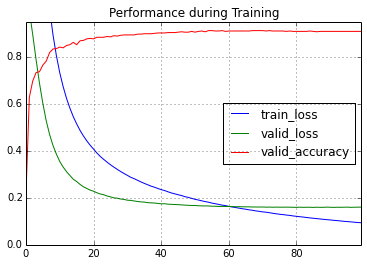

In [17]:
%matplotlib inline
perf[['train_loss','valid_loss','valid_accuracy']].plot(title='Performance during Training', ylim=(0,0.95))

## Task 1 (evaluate the learning phase)
* What is the value of the log-loss for perfect classification?
* [optional] What is the value for the log-loss for random assignment to the classes?
* Describe the form of the curve

## Task 1 (LSG)
* 0 since log(1)=0
* For random assinment the probability for each class ist 1/10. So ln(1/10) = -2.3. Hence J = 2.3
* The training loss reaches the optimal value of 0 but the validation loss on the untouched validation set goes to goes up a again. This indicates overfitting to the training set.

## Task 2 (evaluate on testset)
Now that we have fixed the weights of the network, we can make predictions on unseen data 3000-4000 and evaluate the performance. We first have to compile a function using the input and output variables.

In [39]:
pred = theano.function([input_var],[test_prediction])
res = pred(X[3000:4000])[0]
np.mean(np.argmax(res, axis=1) == y[3000:4000])

0.91700000000000004

In the notebook [MinimalLasagneCNN.ipynb](MinimalLasagneCNN.ipynb) we show how to use a CNN.